##OpenStreetMap Sample Project Data Wrangling with MongoDB
####Vivek Yadav

###Overview

As Colorado Springs, CO is my favorite city, I downloaded the map of Colorado Springs. Data was downloaded from the predownloaded OSM-XML files on the mapzen website. 

Data Sources:
1. https://mapzen.com/data/metro-extracts
2. https://s3.amazonaws.com/metro-extracts.mapzen.com/colorado-springs_colorado.osm.bz2

The unzipped data was 108.9 MB. 


### Problems Encountered in the Map

After downloading the data, the following main issues were identified:
1. Over-abbreviated street names (“S Union Blvd-->South Union Boulevard”). This issue was fixed using an audit function where street type was corrected by checking against possible abbreviations.
2. Inconsistent entry of street name. In some cases, the street names included part of address, for example, suite number in address. North Nevada Avenue Ste 130'. For 5 such entries, the data were manually corrected.
3. Missing city names, few entries did not have a city name entry. In cases where city names were missing, zipcode package in python was used to get city information from postal code if it existed.
3. Inconsistent postal codes. Postal codes are 5 digit long, and in Colorado springs area, begin with an 8. Only 2 entries were found where postal codes didnt conform to this rule, and they were updated manually.
4. Missing Postal codes, few entries did not have postal code entry. In this case, if the street name and city name existed, geopy package in python was used to get postal codes.
5. Incosistent city naming. In colorado springs, some regions like US Air Force Academy, Fort Carson, Security-Widefield etc use their own names as city names. Although these regions lie within Colorado Springs area. 


### Cleaning and updating addresses

#### Cleaning street names. 
Python functions were written to audit and clean street names and postal codes. A list of expected street names was created, and 'audit' function was used to identify the streets that did not have the expected names. 
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Lane", "Road", 
            "Parkway", "Commons","Circle","Alley","Way","View","Place", "Square","Trail"]
            
After first run, there were around 100 street names whose type was not in expected. Many streets were named using acronyms for the full street type name. For example, Road was labeled at Rd or Rd. Therefore, a mapping dictionary was created to map the short from of the street types used by the user and the full name of the street type.
Further, street types like "Point", "Loop" and "Terrace" were not included in list of expected names. Google search showed that these street types are used to label streets in Colorado Springs. So these street types were added to the list of expected types. Next, a 'update_name' function was used replace short forms with the full name. Further, some streets were labeled by direction, for example S Union Blvd or Union Blvd S. These street names were updated, the update_name command changed the names as follows, 

1. Union Blvd-->Union Boulevard
2. S Union Blvd-->South Union Boulevard
3. Union Blvd S-->South Union Boulevard
4. S. Union Blvd-->South Union Boulevard
5. Union Blvd S.-->South Union Boulevard


The street types that were not found in either expected or short forms were collected in a python dictionary. 

Close examination revealed that 5 streets were not classified into any of the street types. These 5 are listed below. These reveal that 
1. '130': {'North Nevada Avenue Ste 130'},
2. '80829': {'El Paso Blvd, Manitou Springs, CO 80829'},
3. '80919': {'230 Point of the Pines Drive  Colorado Springs, CO 80919'},
4. 'CO': {'1 Lake Avenue  Colorado Springs, CO'},
5. 'Plaza': {'S. Union Blvd, Suite 255, Printers Park Medical Plaza'}

Streets 1 and 5 have Suite information in them, and streets 2-4 were entered wrongly. Therefore, these street names were manually updated after importing data in mongodb. After updating in MongoDb, there were 2 streets that did not have the street type idenfitied correctly. These streets were left unchanged in the mongodb database. 
1. '130': {'North Nevada Avenue Ste 130'},
2. 'Plaza': {'S. Union Blvd, Suite 255, Printers Park Medical Plaza'}


#### Checking zip codes.
It may be possible that zipcodes are entered wrongly by the users, so the following checks were performed. 
1. First the length of postcode entry was checked. Postal code in Coloraro Springs are should be 5 digits. So first step was to check for the length of zipcode entry. Inspection revealed that 2 streets had  postal codes that were not of length 5. 
    - 2951,East Dale Street, postcode-1875. 
    - 505, East Columbia Street, Colorado springs, postcode-CO.

2. Next step was to verify if all the postcodes were numeric. Therefore, str.isnumeric() command in python was used to test if the string supplied by the user for postcode is infact numeric. This inspection revealed all the entries were infact numeric. 
3. Postal codes in Colorado Springs area begin with 8, therefore, the first digit of the postal code was checked to verify if it is 8. 

#### Checking city names.
It may be possible that postal codes and city names are entered wrongly by the users, so to verify if the city names correspond with the postal codes, the zipcode package was used to get city information from postal codes. After comparing city name entered by the user and results from zipcode package, the following city names did not match between user entry and check from zipcode. All the entries below were identified as Colorado Springs by the zipcode package. 

- 'Colorado springs',
- 'colorado springs, CO'
- 'Fort Carson',
- 'Security',
- 'Security-Widefield',
- 'Widefield'

The first 2 have formatting issue. Fort Carson is a military installation in Colorado Springs, and several addresses list this for City information. So the city information was not updated for addresses with city listed as Fort Carson. Security and Widefeld are censor designated areas in southern Colorado Springs and fall under the same area called Security-Widefield. Therefore, the area names were updated to Security-Widefield. 

 
####  Updating city data

Many address entries did not have city information. Of the all the address records, only 7252 of the addresses did not have city information. However, 4826 of 7252 missing city entries had postal code information. Therefore, postal code information was used to identify city from the data using 'zipcode' package. It is important to note that all the addresses in Colorado Springs area have Colorado Springs as the city. Manitou Springs, Fountain, US Air Force Academy, etc are within Colorado Springs area, but are different cities. To get city information form postal code, a zipcode library was used. This library took zipcode of area as input and gave location information for the postal code.

mapping_cities = { "Colorado springs": "Colorado Springs",
            "colorado springs, CO": "Colorado Springs",
            "United States Air Force Academy":"US Air Force Academy",
            "U S A F Academy":"US Air Force Academy",
            "Security": "Security-Widefield",
            "Widefield": "Security-Widefield",
                }

####  Updating postalcode data
There were some addresses that did not have postal code information, but had information about the street and city. In such cases, geopy package was used to get postal code from the partial address information. For example, Rockledge Lane, Colorado Springs, CO did not have the postal code information. Postal code information was obtained using geopy package, and the address was updated as: Rockledge Lane, Manitou Springs, CO 80829. 1696 addresses did not have postal code information. For these addresses, the postal codes were obtained using geopy package, and checked to confirm if the first digit started with an 8, if it did, the postal codes were updated. After updating 367 address entries did not have post code information. 


### summary of cleaning:
Before cleaning, 15789 addresses had both city and post code information, after cleaning this number increased to 20742 of 23183. 
 - Postal codes were used to get city information for 4826 address entries. 
 - 1329 postal codes were obtained using geopy package.

### Conclusions:

After review, it is clear that the data for Colorado Springs is incomplete. I updated city names and postal code using zipcode and geopy packages. By using these techniques, the percentage of entries with street, postal code and city data increased from 68 to around 90. However, inspite of using this, there were several street names for which I could not get postal code. Following analysis steps can be used to further clean the data
1. Compare partial address query results from multiple sources (google, yahoo, mapquest, etc) and see if one of the packages provides postal code information.
2. I kept getting service time out error, and for these addresses google search did not provide a valid entry. For these addresses GPS data (longitude and latitude) can be used to get city and postal code information.
3. By checking user entries with GPS location, and using auditing methods while address is entered, a cleaner data can be obtained.

###Link to individual sections of code are below. 

1.  [Importing libraries](#import_files)
2.  [Functions to check and update street names](#chkupdt_files)
3.  [Loading data and checking unexpected street names](#audit_data)
4. [Udating street types](#update_data)
5.  [Importing data to mongodb](#import_Mdb)
    1. [Manually updating 3 street names](#import_Mdb)
6. [Checking and Udating city names based on postal codes](#update_city)
    1. Checking if the city name from zipcode and city name entered by the user match.
    2. For addresses with zip code and without city name, updating name of the city.
7. [Updating postal codes based on street and city names.](#update_zip)
8.  [Some interesting facts about data](#some_facts): 
       - There are total of 1653045 entries in Colorado springs data base of which 16731 are street addresses. Of these, 79 entries had street names in unexpected format. After cleaning, this number dropped to 2. 
       - Of the 1653045 entries, about 75% were by one user "FrozenFlame22" and 91% from the top 10 users. 
       - Among restaurants, Village Inn has the most entries with 15 followed by pizza hut at 12. 
       - The most common amenity is 'Parking'. The top 3 data uploads were for parking (5658), restaurant (639) and school (558).
       


### <a id='import_files'>Importing Libraries</a>

In [1]:
# Importing libraries:
import pymongo
import xml.etree.cElementTree as ET
import re
from collections import defaultdict
import pprint
import codecs
import json
import matplotlib.pyplot as plt
import zipcode
from geopy.geocoders import Nominatim
geolocator = Nominatim()
%pylab inline


# Make sure to run mongodb in terminal
# command: mongod --dbpath /Users/vivekyadav/mongodb
# https://wiki.openstreetmap.org/wiki/Main_Page

Populating the interactive namespace from numpy and matplotlib


### <a id='chkupdt_files'>Functions to check and update street names. </a>
Below are functions written to look for streets name, and check if the formatting is correct. 

In [2]:
# functions 

# Function to count number of tags
def count_tags(filename):
        # YOUR CODE HERE
        file_parse = ET.iterparse(filename)
        tag_all_names = {}
        for tag_name in file_parse:
            key = tag_name[1].tag
            d = dict(tag_all_names)
            if key in d:
                tag_all_names[key] = tag_all_names[key] + 1
            else:
                tag_all_names[key] = 1
                
        return tag_all_names
    
# Function to check if street type is in the 'expected' list.
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

# Function to update street type based on entries from a mapping function.
def update_name(name, mapping,directions):
    name_spl = name.split(' ')
    if name_spl[len(name_spl)-1] in directions:
        name = name_spl[len(name_spl)-1]
        for i in range(1,len(name_spl)):
            name = name + " " + name_spl[i-1]
    name_spl = name.split(' ')
    if name_spl[len(name_spl)-1] in mapping:
        name = name.replace(name_spl[len(name_spl)-1], mapping[name_spl[len(name_spl)-1]])
    if name_spl[0] in directions:
        name = name.replace(name_spl[0], directions[name_spl[0]])
        
    return name

# Function to audit map file. 
def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    return street_types



# Function to write data from OSM file into dictionary for mongodb. 
def shape_element(element):
    st_types_not_found = defaultdict(set)
    node = {}
    
    if element.tag == "node" or element.tag == "way" :
        
        # YOUR CODE HERE
        nd_refs = []
        if element.tag == 'way':
            
            for nd in element.iter('nd'):
                nd_refs.append(nd.attrib['ref'])
            node['node_refs'] = nd_refs
            #print nd_refs
        
        node['id'] =  element.get('id')
        node['type'] = element.tag
        node['visible'] = element.get('visible')
        node['created'] = {}
        node['created']['version'] = element.get('version')
        node['created']['timestamp'] = element.get('timestamp')
        node['created']['changeset'] = element.get('changeset')
        node['created']['user'] = element.get('user')
        node['created']['uid'] = element.get('uid')
        ln = eval(str(element.get('lon')))
        lt = eval(str(element.get('lat')))
        
        node['pos'] = [ (lt), (ln)]
        addr_dict = {}
        for tag in element.iter('tag'):
            if tag.get('k')[:4]=='addr':
                if tag.get('k')== 'addr:street':
                    name = tag.get('v')
                    updated_name_street = update_name_dict(st_types,name, mapping,st_directions)
                    if updated_name_street == 0:
                        addr_dict['street'] = tag.get('v')
                    else:
                        addr_dict['street'] = updated_name_street
                    
                if tag.get('k')== 'addr:housenumber':
                    addr_dict['housenumber'] = tag.get('v')
                if tag.get('k')== 'addr:city':
                    addr_dict['city'] = tag.get('v')
                if tag.get('k')== 'addr:postcode':
                    addr_dict['postcode'] = tag.get('v')
                addr_dict['state'] = 'CO'
            else:
                node[tag.get('k')] = tag.get('v')                    
            if addr_dict != {}:
                node['address'] = addr_dict
                
        return node
    else:
        return None

    
# Function to write data from OSM file into dictionary for mongodb.    
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

# Function to update street name    
def update_name_dict(st_types,name, mapping,directions):
    st_types_not_found = defaultdict(set)
    i_print = 0
    for key in st_types:
        for street_name in st_types[key]:
            name_spl = name.split(' ')
            name_street_type = name_spl[len(name_spl)-1]
            if name_street_type in mapping:
                better_name = update_name(name, mapping,directions)
                if i_print<10:
                    print(  name  + ' --> ' + better_name)
                    i_print = i_print+1
                return better_name
            else:
                st_types_not_found[key].add(street_name)            
                return 0
# Function to check if a street type is in a dictionary 'mapping' and update street name.           
def check_street_names_with_mapping(st_types_in, mapping,directions):
    st_types_not_found = defaultdict(set)
    for key in st_types_in:
        for street_name in st_types_in[key]:
            name_spl = street_name.split(' ')
            name_street_type = name_spl[len(name_spl)-1]
            if name_street_type in mapping:
                better_name = update_name(street_name, mapping,directions)
            else:
                st_types_not_found[key].add(street_name)
    return st_types_not_found

# Function to get city information from Zipcode.
def get_city_zip(city_nm):
    city_spl = city_nm.split(" ")
    city_apnd = ""
    for i_cspl in range(0,len(city_spl)):
        city_apnd = city_apnd + city_spl[i_cspl][0].upper() + city_spl[i_cspl][1:len(city_spl[i_cspl])].lower()
        if (i_cspl < len(city_spl)-1):
            city_apnd = city_apnd + " "
    city_all.append(city_apnd)
    return city_all


# Function to check Zipcode.
def check_postcode(post_code):
    check_var = 1
    if len(post_code)!=5:
        check_var = 0 # String should be of length 5.
    if str.isnumeric(post_code)==False:
        check_var = 0 # String should be a numeric
    if post_code[0]!='8': 
        check_var = 0 # First digit should be 8, for all CO-spring addresses
    return check_var

### <a id='audit_data'>Loading data and checking unexpected street types. </a>
Loading data of Colorado Springs. 

In [4]:
filename = 'colorado-springs_colorado.osm'
num_tags = count_tags(filename)
pprint.pprint(num_tags)

{'bounds': 1,
 'member': 1260,
 'nd': 587863,
 'node': 493059,
 'osm': 1,
 'relation': 193,
 'tag': 217826,
 'way': 57956}


Next, the types of street names are checked. It is expected that most street names will be "Street", "Avenue", "Boulevard", "Drive", "Court", "Lane", "Parkway", "Commons","Circle","Alley","Way","View","Place", "Square","Trail" or "Road". 

In [5]:
# Regular expression to check for street type and expected street names
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Lane", "Road", 
            "Parkway", "Commons","Circle","Alley","Way","View","Place", "Square","Trail"]

In [6]:
# Checking all street types that are not in 'expected' list
st_types = audit(filename)
pprint.pprint(st_types)

{'130': {'North Nevada Avenue Ste 130'},
 '80829': {'El Paso Blvd, Manitou Springs, CO 80829'},
 '80919': {'230 Point of the Pines Drive  Colorado Springs, CO 80919'},
 '83': {'Highway 83'},
 '85': {'South Highway 85'},
 'Aly': {'Kempton Aly'},
 'Ave': {'E Pikes Peak Ave',
         'East Pikes Peak Ave',
         'Gilpin Ave',
         'N Nevada Ave',
         'Skyline Ave',
         'West Colorado Ave',
         'West Platte Ave'},
 'Ave.': {'W. Moreno Ave.', 'Colorado Ave.'},
 'Blvd': {'N Academy Blvd', 'N Union Blvd'},
 'Boulefard': {'North Academy Boulefard'},
 'Building': {'East Pikes Peak Building'},
 'CO': {'1 Lake Avenue  Colorado Springs, CO'},
 'Cascade': {'South Cascade'},
 'Chelton': {'N Chelton'},
 'Costilla': {'East Costilla'},
 'Ct': {'Beechwood Ct'},
 'Dr': {'Dorset Dr',
        'Ellingwood Dr',
        'Hanham Dr',
        'Lake Plaza Dr',
        'St Paul Dr',
        'iveDorset Dr'},
 'Dr.': {'802 Village Center Dr.', 'Explorer Dr.', 'Acacia Dr.'},
 'Expressway': {'H

In [7]:
# Number of streets with non-corforming street type entries.
num_nonConf = 0
for key in st_types:
    num_nonConf = num_nonConf + len(st_types[key])
print(num_nonConf)

79


### <a id='update_data'>Updating street names. </a>


Many streets are named using acronyms for the full street type name. For example, Road is labeled at Rd or Rd. In some places. Therefore, a mapping dictionary is created to map the short from of the street types used by the user and the full name of the street type. 

Further, street types like "Point", "Loop" and "Terrace" were not included in names. Google search showed that these street types are actually used to label streets in Colorado Springs. So these street types were added to expected list. 

Next, a update_name function was used replace short forms with the full name. The street types that were not found in either expected or short forms were collected in a python dictionary. 

In [8]:
# Adding additional street types to expected, and making a mapping vector to map abbreviations to full name.

mapping = { "St": "Street",
            "St.": "Street",
            "Rd.":"Road",
            "Rd":"Road",
            "Ave.":"Avenue",
            "Ave ":"Avenue",
            "Ave": "Avenue",
            "Dr" : "Drive",
            "Dr." : "Drive",           
            "Blvd": "Boulevard",
            
            }
            
expected.append('Terrace') 
expected.append('Point')
expected.append('Loop')

st_directions = { "S": "South",
            "S.": "South",
            "N.":"North",
            "N":"North",
            "W.":"West",
            "W ":"West",
            "E.": "East",
            "E" : "East",
            "West":"West",
            "East":"East",
            "North":"North",
            "South":"South",
            }

st_types = audit(filename)
st_types_not_found = check_street_names_with_mapping(st_types, mapping,st_directions)
pprint.pprint(st_types_not_found)

{'130': {'North Nevada Avenue Ste 130'},
 '80829': {'El Paso Blvd, Manitou Springs, CO 80829'},
 '80919': {'230 Point of the Pines Drive  Colorado Springs, CO 80919'},
 '83': {'Highway 83'},
 '85': {'South Highway 85'},
 'Aly': {'Kempton Aly'},
 'Boulefard': {'North Academy Boulefard'},
 'Building': {'East Pikes Peak Building'},
 'CO': {'1 Lake Avenue  Colorado Springs, CO'},
 'Cascade': {'South Cascade'},
 'Chelton': {'N Chelton'},
 'Costilla': {'East Costilla'},
 'Ct': {'Beechwood Ct'},
 'Expressway': {'Hancock Expressway'},
 'Nevada': {'S. Nevada'},
 'Pkwy': {'Briargate Pkwy'},
 'Pl': {'Oak Pl', 'Terrace Pl', 'Santa Fe Pl', 'Plainview Pl', 'Poplar Pl'},
 'Plaza': {'S. Union Blvd, Suite 255, Printers Park Medical Plaza'},
 'Pt': {'New Center Pt'},
 'S': {'Circle Dr S'},
 'South': {'Nonchalant Circle South'},
 'Tejon': {'South Tejon'},
 'Union': {'West Union'},
 'West': {'Oak Creek Drive West', 'Nolte Drive West'}}


There were a few street types that were not included in the original expected list. So the list of expected was updated by adding "Expressway", "Highway 83" and "Highway 85". Further inspection revealed that Pikes Peak Building is a property and not a street. However, as there was only 1 entry, this entry was left as it is. 

Further inspection revealed that some of the short forms of the street names were not included in the original mapping, and some street names were labeled without street types in them. So the mapping dictionary was updated to add more short forms and street types to streets that didnt have the street type.

In [9]:
# Adding additional street types to expected, and making a mapping vector to map abbreviations to full name.

expected.append('Expressway')
expected.append('83')
expected.append('85')
expected.append('Building')

mapping['Boulefard'] = 'Boulevard' 
mapping['Pkwy'] = 'Parkway' 
mapping['Aly'] = 'Alley'
mapping['Pl'] = 'Place'
mapping['Pt'] = 'Point'
mapping['Ct'] = 'Court'
mapping['Costilla'] = 'Costilla Street'
mapping['Nevada'] = 'Nevada Avenue'
mapping['Tejon'] = 'Tejon Street'
mapping['Chelton'] = 'Chelton Road'
mapping['Cascade'] = 'Cascade Avenue'
mapping['Union'] = 'West Union Boulevard'
mapping.update(st_directions)

Same street name can be written in different formats when direction (North, South, East, West) information is included. Therefore, these street names were updated so the direction is first. 

In [10]:
# Checking the update streettype function
st_nm_arr = ['Union Blvd',
             'S Union Blvd',
             'Union Blvd S',
             'S. Union Blvd',
             'Union Blvd S.']
for street_name in st_nm_arr:
    btr_nm = update_name(street_name ,mapping,st_directions)
    print(street_name + '-->' +btr_nm)

Union Blvd-->Union Boulevard
S Union Blvd-->South Union Boulevard
Union Blvd S-->South Union Boulevard
S. Union Blvd-->South Union Boulevard
Union Blvd S.-->South Union Boulevard


In [11]:
# Updating street types.

st_types = audit(filename)
st_types = audit(filename)

st_types_not_found = check_street_names_with_mapping(st_types, mapping,st_directions)
pprint.pprint(st_types_not_found)

{'130': {'North Nevada Avenue Ste 130'},
 '80829': {'El Paso Blvd, Manitou Springs, CO 80829'},
 '80919': {'230 Point of the Pines Drive  Colorado Springs, CO 80919'},
 'CO': {'1 Lake Avenue  Colorado Springs, CO'},
 'Plaza': {'S. Union Blvd, Suite 255, Printers Park Medical Plaza'}}


Based on the list above, there are 5 addresses that are not resolved. For these addresses, the street numbers are entered as the entire address. These addresses will be resolved after importing them in Mongodb.

In [12]:
# Updating street types.

print("########################")
print("########################")
print("Addresses with non-conforming street names:")
print("Old name --> New Name")
print("########################")

data_map = process_map(filename,False)


########################
########################
Addresses with non-conforming street names:
Old name --> New Name
########################
Colorado Ave. --> Colorado Avenue
New Center Pt --> New Center Point
N Academy Blvd --> North Academy Boulevard
Skyline Ave --> Skyline Avenue
West Platte Ave --> West Platte Avenue
802 Village Center Dr. --> 802 Village Center Drive
St Paul Dr --> St Paul Drive
Evesham St --> Evesham Street
West Colorado Ave --> West Colorado Avenue
West Union --> West West Union Boulevard
East Boulder St. --> East Boulder Street
South Cascade --> South Cascade Avenue
South Tejon St --> South Tejon Street
East Pikes Peak Ave --> East Pikes Peak Avenue
South Tejon --> South Tejon Street
S. Nevada --> South Nevada Avenue
Waynoka Rd --> Waynoka Road
S Tejon St --> South Tejon Southtreet
N. El Paso St. --> North El Paso Street
Bear Creek Rd --> Bear Creek Road
Terrace Pl --> Terrace Place
Oak Pl --> Oak Place
Plainview Pl --> Placeainview Place
Plainview Pl --> Place

In [13]:
# street types not found in expected or after updating.
pprint.pprint(st_types_not_found)

{'130': {'North Nevada Avenue Ste 130'},
 '80829': {'El Paso Blvd, Manitou Springs, CO 80829'},
 '80919': {'230 Point of the Pines Drive  Colorado Springs, CO 80919'},
 'CO': {'1 Lake Avenue  Colorado Springs, CO'},
 'Plaza': {'S. Union Blvd, Suite 255, Printers Park Medical Plaza'}}


### <a id='import_Mdb'>Importing data to mongodb </a>
Data is now imported into mongoDB

In [4]:
# Adding data to mongoDB

def drop_db():
    db.CoSprings.drop()

# db.CoSprings.drop() command to drop database.
    
def get_db():
    from pymongo import MongoClient
    client = MongoClient('localhost:27017')
    db = client.examples
    return db
db = get_db()
db.CoSprings.insert(data_map)
print("Data added to mongoDb")

Data added to mongoDb


In [5]:
db.CoSprings.find_one()

{'_id': ObjectId('5683d5d69f81c615f098773c'),
 'created': {'changeset': '16933109',
  'timestamp': '2013-07-13T05:00:28Z',
  'uid': '227972',
  'user': 'Your Village Maps',
  'version': '37'},
 'id': '32658042',
 'pos': [38.8970934, -104.8302179],
 'type': 'node',
 'visible': None}

In [21]:
# Checking post code entries for format

pipeline = [{"$match":{"address.postcode":{"$exists":1}}}, 
            {"$group":{"_id":"$address", 
                       "count":{"$sum":1}}}, 
            {"$sort":{"count":-1}}]
search_postcode= db.CoSprings.aggregate(pipeline)
a_list = []
for a in search_postcode:
    a_list.append(a)
    print_var = check_postcode(a['_id']['postcode'])
    if print_var == 0:
        pprint.pprint(a)
    

{'_id': {'housenumber': '2951',
         'postcode': '1875',
         'state': 'CO',
         'street': 'East Dale Street'},
 'count': 1}
{'_id': {'city': 'Colorado Springs',
         'housenumber': '505',
         'postcode': 'CO',
         'state': 'CO',
         'street': 'East Columbia Street'},
 'count': 1}


There are 2 addresses with entries that do not match standard zipcode format. These entries were manually updated using output from google maps. 

In [22]:
post_add1 = db.CoSprings.find_one({'address.postcode':'1875'})
postalcode_before = post_add1['address']['postcode']
post_add1['address']['postcode']='80909'
postalcode_after = post_add1['address']['postcode']
print('Postal code changed from ' + postalcode_before + ' to ' + postalcode_after)
db.CoSprings.save(post_add1)

post_add1 = db.CoSprings.find_one({'address.postcode': 'CO'})
post_add1['address']['postcode']='80907'
post_add1['address']['state']='CO'
db.CoSprings.save(post_add1)

Postal code changed from 1875 to 80909


ObjectId('5687fe649f81c64a012625d6')

### <a id='update_city'>Checking city names based on zip codes. </a>

In [24]:
# Checking how many address entries have city, street and post code information, but have postal code data.

pipeline = {"address":{"$exists":1},
            "address.street":{"$exists":1},
            "address.city":{"$exists":1},
            "address.postcode":{"$exists":1}
            }
num_all_adr = db.CoSprings.find(pipeline).count()
pipeline = {"address":{"$exists":1},
            }
num_all = db.CoSprings.find(pipeline).count()

print(str(num_all_adr) + " of " + str(num_all) + " addresses have street, city and postcode information")

15798 of 23183 addresses have street, city and postcode information


In [29]:
# Checking how many address entries have city and post code information, but have postal code data. 
# This block compares street names from data base entries and city information from zipcode package.

pipeline = {"address":{"$exists":1},
            "address.city":{"$exists":1},
            "address.postcode":{"$exists":1}
            }
num_all_adr = db.CoSprings.find(pipeline).count()
print(num_all_adr)
all_adr = db.CoSprings.find(pipeline)                                               
city_all = []
city_not_in_list = []
i_city = 0
for a in all_adr:
    zp = a['address']['postcode']
    myzip = zipcode.isequal(zp)
    city_nm = myzip.city
    city_spl = city_nm.split(" ")
    city_apnd = ""
    for i_cspl in range(0,len(city_spl)):
        city_apnd = city_apnd + city_spl[i_cspl][0].upper() + city_spl[i_cspl][1:len(city_spl[i_cspl])].lower()
        if (i_cspl < len(city_spl)-1):
            city_apnd = city_apnd + " "
    city_all.append(city_apnd)
    
    if a['address']['city'] != city_apnd:
        city_not_in_list.append(a['address']['city'])
        if i_city<10:
            i_city = i_city+1
            print(a['address']['city'] + ' : ' + city_apnd +  ' : ' + a['address']['postcode'])


print('')
print('')
print('Cities not in the expected city list:')
pprint.pprint(set(city_not_in_list))

15842
US Air Force Academy : U S A F Academy : 80840
US Air Force Academy : U S A F Academy : 80840
US Air Force Academy : U S A F Academy : 80840
Security-Widefield : Colorado Springs : 80911
Security-Widefield : Colorado Springs : 80911
Fort Carson : Colorado Springs : 80913
Fort Carson : Colorado Springs : 80913
Fort Carson : Colorado Springs : 80913
Fort Carson : Colorado Springs : 80913
Fort Carson : Colorado Springs : 80913
Cities not in the expected city list:
{'Colorado springs',
 'Fort Carson',
 'Security',
 'Security-Widefield',
 'US Air Force Academy',
 'Widefield',
 'colorado springs, CO'}


In [30]:
# Checking how many address entries do not have city information, but have postal code data.
pipeline = {"address":{"$exists":1},
            "address.city":{"$exists":0},
            }
num_all_adr = db.CoSprings.find(pipeline).count()
print(str(num_all_adr) + " addresses do not have city infromation")


pipeline = {"address":{"$exists":1},
            "address.city":{"$exists":0},
            "address.postcode":{"$exists":1}
            }
num_all_adr = db.CoSprings.find(pipeline).count()
print(str(num_all_adr) + " addresses do not have city infromation, but have postal code information.")        

7252 addresses do not have city infromation
4826 addresses do not have city infromation, but have postal code information.


We find 7252 addresses do not have city information. Of these 4826 addresses have postcode. Therefore, this information can be used to update city names. 

In [31]:
# Updating city names based on postal code.
pipeline = {"address":{"$exists":1},
            "address.city":{"$exists":0},
            "address.postcode":{"$exists":1}
            }
num_all_adr = db.CoSprings.find(pipeline).count()
print(str(num_all_adr) + " addresses have postal code information, but no city information")
all_adr = db.CoSprings.find(pipeline)                                               
city_all = []
for a in all_adr:
    zp = a['address']['postcode']
    myzip = zipcode.isequal(zp)
    city_nm = myzip.city
    city_spl = city_nm.split(" ")
    city_apnd = ""
    for i_cspl in range(0,len(city_spl)):
        city_apnd = city_apnd + city_spl[i_cspl][0].upper() + city_spl[i_cspl][1:len(city_spl[i_cspl])].lower()
        if (i_cspl < len(city_spl)-1):
            city_apnd = city_apnd + " "
    city_all.append(city_apnd)
    a['address']['city'] = city_apnd
    db.CoSprings.save(a)
set(city_all)

4826 addresses have postal code information, but no city information


{'Colorado Springs',
 'Fountain',
 'Glenwood Springs',
 'Guffey',
 'Joes',
 'Manitou Springs',
 'Steamboat Springs',
 'U S A F Academy'}

In [36]:
# Updating city names based on postal code.
pipeline = {"address":{"$exists":1},
            "address.city":{"$exists":0},
            "address.postcode":{"$exists":1}
            }
num_all_adr = db.CoSprings.find(pipeline).count()
print('After updating ' + str(num_all_adr) + " addresses had postal code information, but no city information. Therefore, 4826 cities were updated.")


After updating 0 addresses had postal code information, but no city information. Therefore, 4826 cities were updated.


Some city names were entered differently in the data base, further some addresses, different city names are used to refer to the same city. In this case, city names were updated using a mapping function.

In [37]:
# Updating city names' abbreviations and other names.

pipeline = {"address":{"$exists":1},
            "address.city":{"$exists":1},
            }
num_all_city = db.CoSprings.find(pipeline).count()
print(num_all_city)
all_adr = db.CoSprings.find(pipeline)                                               
city_all = []
for a in all_adr:
    city_all.append(a['address']['city'])
set(city_all)

mapping_cities = { "Colorado springs": "Colorado Springs",
            "colorado springs, CO": "Colorado Springs",
            "United States Air Force Academy":"US Air Force Academy",
            "U S A F Academy":"US Air Force Academy",
            "Security": "Security-Widefield",
            "Widefield": "Security-Widefield",
                }



20757


In [38]:
# Updating city names' abbreviations and other names.
for city_name in mapping_cities:
    print(city_name)
    
    pipeline = {"address":{"$exists":1},
          
                "address.city":city_name
               }
    num_all_city = db.CoSprings.find(pipeline).count()
    post_add1 = db.CoSprings.find(pipeline)
    for a in post_add1:
        a['address']['city'] = mapping_cities[city_name]
        db.CoSprings.save(a)

    


Colorado springs
colorado springs, CO
U S A F Academy
Security
United States Air Force Academy
Widefield


In [39]:
# Checking if abbreviations or other inconsistent names' occurance after updating. 
for city_name in mapping_cities:
    
    pipeline = {"address":{"$exists":1},
                "address.city":city_name
               }
    num_all_city = db.CoSprings.find(pipeline).count()
    print(city_name + " :- " + str(num_all_city))

Colorado springs :- 0
colorado springs, CO :- 0
U S A F Academy :- 0
Security :- 0
United States Air Force Academy :- 0
Widefield :- 0


### <a id='update_zip'>Updating postal codes based on street and city names. </a>

In [29]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("Manitou Avenue, Colorado Springs, CO")
if location != None:
    post_code = location.address.split(', ')[len(location.address.split(', '))-2]
    print(post_code)

80487


In [44]:
pipeline = {"address":{"$exists":1},
            "address.street":{"$exists":1},
            "address.postcode":{"$exists":0},
            }
print(str(db.CoSprings.find(pipeline).count()) + " address entries have street information, but no zipcode")


1696 address entries have street information, but no zipcode


1696 address entries have street information, but no zipcode information. Therefore, the postal code information can be updated using street names. When city information existed, city name was used. If no city information was provided in the data base, a default of 'Colorado Springs' was used. 

In [19]:
# Updating zipcode from street and city data.
# This section gave service time out errors, so this section was run multiple times, until all addresses were updated.
pipeline = {"address":{"$exists":1},
            "address.street":{"$exists":1},
            "address.postcode":{"$exists":0},
            }
print(db.CoSprings.find(pipeline).count())
add_cur = db.CoSprings.find(pipeline)
i_print = 0
    
for a in add_cur:
    #pprint.pprint(a)
    addr_string = ""
    fields = a['address']
    addr_string = a['address']['street']
    if 'city' in fields: 
        addr_string = addr_string + "," + a['address']['city']
        addr_string = addr_string + ", CO"
    else:    
        addr_string = addr_string + ", Colorado Springs"
        addr_string = addr_string + ", CO" 
    print(addr_string)
    location = geolocator.geocode(addr_string)
    if location != None:
        post_code = location.address.split(', ')[len(location.address.split(', '))-2]
        print_var = check_postcode(post_code)
        if print_var == 1:    
            a['address']['postcode'] = post_code
            db.CoSprings.save(a)
            if i_print<10:
                print("Street name: " + addr_string + ', post code added: ' + post_code)
                i_print = i_print+1


367
Gami Way, Colorado Springs, CO
4791 Gami Way, Colorado Springs, CO
Gami Way, Colorado Springs, CO
West West Union Boulevard, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Santa Fe Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Santa Fe Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
Santa Fe Place, Colorado Springs, CO
Santa Fe Place, Colorado Springs, CO
Santa Fe Place, Colorado Springs, CO
Santa Fe Place, Colorado Springs, CO
Placeainview Place, Colorado Springs, CO
East Boulder 

GeocoderTimedOut: Service timed out

In [25]:
# Checking how many addresses have zipcode missing.
pipeline = {"address":{"$exists":1},
            "address.street":{"$exists":1},
            "address.postcode":{"$exists":0},
            }
print(str(db.CoSprings.find(pipeline).count()) + "  addresses have post code missing")

367  addresses have post code missing


In [33]:
# Checking how many addresses have zipcode missing.
pipeline = {"address":{"$exists":1},
            }
num_all = db.CoSprings.find(pipeline).count()

pipeline = {"address":{"$exists":1},
            "address.city":{"$exists":1},
            "address.postcode":{"$exists":1},
            }
num_all_adr = db.CoSprings.find(pipeline).count()
print(str(num_all_adr) + " of " + str(num_all) + " addresses do not have both city and post code data")

20742 of 23183 addresses do not have both city and post code data


Before updating, 15842 streets had both city and post  code information. After updating city names using post codes, and post codes using street and city names, this number increased to 20742.

In [34]:
pipeline = {"address":{"$exists":1},
            "address.street":{"$exists":1},
            "address.postcode":{"$exists":0},
            }
print(db.CoSprings.find(pipeline).count())

367


#### <a id='import_Mdb'>Manually updating 3 street names </a>


In [35]:
post_add1 = db.CoSprings.find_one({'address.street': 'El Paso Blvd, Manitou Springs, CO 80829'})
post_add1['address']['street'] = 'El Paso Boulevard'
post_add1['address']['city'] = 'Manitou Springs'
post_add1['address']['state'] = 'CO'
#pprint.pprint(post_add1)
db.CoSprings.save(post_add1)

post_add1 = db.CoSprings.find_one({'address.street': '1 Lake Avenue  Colorado Springs, CO'})
post_add1['address']['street'] = '1 Lake Avenue'
post_add1['address']['city'] = 'Colorado Springs'
post_add1['address']['state'] = 'CO'
#pprint.pprint(post_add1)
db.CoSprings.save(post_add1)

post_add1 = db.CoSprings.find_one({'address.street': '230 Point of the Pines Drive  Colorado Springs, CO 80919'})
post_add1['address']['Point of the Pines Drive'] = '1 Lake Avenue'
post_add1['address']['city'] = 'Colorado Springs'
post_add1['address']['state'] = 'CO'
post_add1['address']['housenumber'] = '230'
#pprint.pprint(post_add1)
db.CoSprings.save(post_add1)



ObjectId('5683d5db9f81c615f09a2f7c')

In [36]:
pipeline = {"address":{"$exists":1}
            }
print(db.CoSprings.find(pipeline).count())

pipeline = {"address":{"$exists":1},
            "address.street":{"$exists":1},
            "address.postcode":{"$exists":1},
            "address.city":{"$exists":1},
            }
print(db.CoSprings.find(pipeline).count())


23183
20686


#### <a id='some_facts'>Some interesting facts about data </a>

There are total of 1653045 entries in Colorado springs data base of which 16731 are street addresses. Of these, 79 entries had street names in unexpected format. After cleaning, this number dropped to 2. Next number of data updates from individual users are quantified.  


{'_id': 'FrozenFlame22', 'count': 843172}
{'_id': 'CS_Mur', 'count': 36812}
{'_id': 'Your Village Maps', 'count': 30842}
{'_id': 'Jason R Surratt', 'count': 30406}
{'_id': 'GPS_dr', 'count': 24908}
{'_id': 'Chris CA', 'count': 14306}
{'_id': 'Mark Newnham', 'count': 6216}
{'_id': 'gpspilot1', 'count': 5678}
{'_id': 'arezookeeper', 'count': 5444}
{'_id': 'SpenSmith', 'count': 5360}
1003144


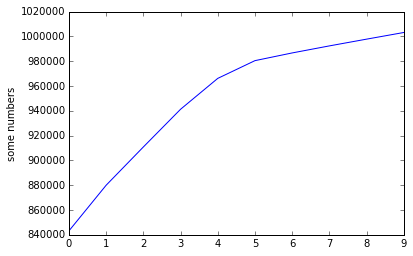

In [26]:
usr_csr = db.CoSprings.aggregate([{"$group":{"_id":"$created.user", 
                                             "count":{"$sum":1}}}, 
                                  {"$sort":{"count":-1}},
                                  {"$limit":10}
                                 ])
usr_list = []
num_10 = 0
num_usr_list = []
for a in usr_csr:
    pprint.pprint(a)
    num_10 = num_10+a['count']
    num_usr_list.append(num_10)
print(num_10)

plt.plot(num_usr_list)
plt.ylabel('some numbers')
plt.show()

In [27]:
print(num_usr_list)

[843172, 879984, 910826, 941232, 966140, 980446, 986662, 992340, 997784, 1003144]


Of the 1653045 entries, about 75% were by one user "FrozenFlame22" and 91% from the top 10 users. The restaruants are investigated next. Village Inn has the most entries with 15 followed by pizza hut at 12. 

In [28]:
restaurants_csr = db.CoSprings.aggregate([
        {"$match" : {"amenity" : "restaurant"}},
        {"$group" : {"_id" : "$name",
                     "count" : {"$sum" : 1}}
        },
        {"$sort" : {"count" : -1},
        },
        {"$limit" : 10,
        }
    ])
restaurants_list = []
for a in restaurants_csr:
    pprint.pprint(a)

{'_id': None, 'count': 22}
{'_id': 'Village Inn', 'count': 10}
{'_id': 'Pizza Hut', 'count': 8}
{'_id': 'Red Robin', 'count': 6}
{'_id': "Louie's Pizza", 'count': 6}
{'_id': 'Einstein Brothers Bagels', 'count': 4}
{'_id': 'Bhan Thai', 'count': 4}
{'_id': 'Borriello Brothers NY Pizza', 'count': 4}
{'_id': "King's Chef Diner", 'count': 4}
{'_id': "Panino's Italian Restaurant", 'count': 4}


In [ ]:
pipeline = [{"$match":{"address":{"$exists":1},
                       "address.city":{"$exists":0},
                       "address.postcode":{"$exists":1}
            }}, 
            {"$group":{"_id":"$address.postcode",
                       "count":{"$sum":1}}}, 
            {"$sort":{"count":-1}},
           {"$limit":10}]

city_csr = db.CoSprings.aggregate(pipeline)
for a in city_csr:
    pprint.pprint(a)

Among amenities, the top 3 data uploads were for parking (5658), restaurant (639) and school (558).

In [228]:
pipeline = [{"$match":{"amenity":{"$exists":1}}}, 
            {"$group":{"_id":"$amenity",
                       "count":{"$sum":1}}}, 
            {"$sort":{"count":-1}}, {"$limit":10}]


amenities_csr = db.CoSprings.aggregate(pipeline)
amenities_list = []
for a in amenities_csr:
    pprint.pprint(a)

{'_id': 'parking', 'count': 1886}
{'_id': 'restaurant', 'count': 213}
{'_id': 'school', 'count': 186}
{'_id': 'fast_food', 'count': 144}
{'_id': 'post_box', 'count': 100}
{'_id': 'bench', 'count': 95}
{'_id': 'fuel', 'count': 86}
{'_id': 'place_of_worship', 'count': 70}
{'_id': 'bank', 'count': 57}
{'_id': 'toilets', 'count': 39}


In [38]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import xml.etree.ElementTree as ET  # Use cElementTree or lxml if too slow

OSM_FILE = "colorado-springs_colorado.osm"  # Replace this with your osm file
SAMPLE_FILE = "colorado-springs_colorado_sample.osm"


def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'w') as output:
    print(type(output))
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every 10th top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % 10 == 0:
            #print(str(ET.tostring(element, encoding='utf-8')))
            output.write(str(ET.tostring(element, encoding='utf-8')))

    output.write('</osm>')

<class '_io.TextIOWrapper'>


In [31]:
#drop_db()